# DeViSE (Deep Visual-Semantic Embedding Model)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
torch.backends.cudnn.benchmark = True

import fastText as ft

In [3]:
import torchvision.transforms as transforms

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

## Download data

In [11]:
%mkdir data/imagenet

In [12]:
%cd data/imagenet/

/home/ubuntu/data/imagenet


In [13]:
!aria2c --file-allocation=none -c -x 5 -s 5 http://files.fast.ai/data/imagenet-sample-train.tar.gz

 *** Download Progress Summary as of Thu Jul  5 15:24:15 2018 ***              
[#67c134 1.8GiB/2.0GiB(90%) CN:5 DL:28MiB ETA:6s]
FILE: /home/ubuntu/data/imagenet/imagenet-sample-train.tar.gz
-------------------------------------------------------------------------------

[#67c134 2.0GiB/2.0GiB(99%) CN:2 DL:27MiB]                        
07/05 15:24:23 [NOTICE] Download complete: /home/ubuntu/data/imagenet/imagenet-sample-train.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
67c134|OK  |    31MiB/s|/home/ubuntu/data/imagenet/imagenet-sample-train.tar.gz

Status Legend:
(OK):download completed.


In [15]:
!tar -xzf imagenet-sample-train.tar.gz

In [17]:
%ls -la train/ | head -n 10

total 3128
drwxrwxr-x 776 ubuntu ubuntu 24576 Jan 19  2017 ./
drwxrwxr-x   3 ubuntu ubuntu  4096 Jul  5 15:27 ../
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01440764/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01443537/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01491361/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01494475/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01498041/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01514668/
drwxrwxr-x   2 ubuntu ubuntu  4096 Nov 16  2016 n01514859/
ls: write error


In [20]:
%cd ../..

/home/ubuntu


In [28]:
fname = 'n01440764/n01440764_9649.JPEG'

In [22]:
PATH = Path('data/imagenet/')
TMP_PATH = PATH / 'tmp'
TRANS_PATH = Path('data/translate/') # for fastText word vectors
PATH_TRN = PATH / 'train'

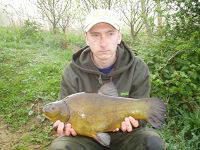

In [104]:
img = Image.open(PATH_TRN / fname)
img

Data pipeline

In [32]:
import fastai

In [33]:
fastai.dataloader.DataLoader

fastai.dataloader.DataLoader

In [35]:
arch = resnet50
ttfms, vtfms = tfms_from_model(arch, 224, transforms_side_on, max_zoom=1.1)

def to_array(x, y):
    return np.array(x).astype(np.float32) / 255, None

def TT(x, y):
    return torch.from_numpy(x), None

ttfms.tfms = [to_array] + ttfms.tfms# + [TT]

In [36]:
ttfms(img)

array([[[ 0.404  ,  0.88463,  0.64182, ...,  1.0088 ,  0.77503,  1.89105],
        [ 0.85854,  1.58429,  1.3317 , ...,  0.89556,  0.72348,  2.00313],
        [ 0.88372,  1.01779,  0.83366, ...,  0.8472 ,  0.74346,  2.149  ],
        ...,
        [-0.00787,  0.28974,  0.65969, ...,  0.52232,  0.59659,  0.68792],
        [-0.03541,  0.33924,  0.60903, ...,  0.60172,  0.66966,  0.78727],
        [-0.14989,  0.30909,  0.56169, ...,  0.39474,  0.54049,  0.76156]],

       [[ 0.70536,  1.2093 ,  0.97274, ...,  1.19664,  0.95415,  2.06959],
        [ 1.1683 ,  1.91048,  1.66838, ...,  1.08087,  0.90103,  2.18123],
        [ 1.1923 ,  1.33133,  1.1534 , ...,  1.03143,  0.92103,  2.32741],
        ...,
        [ 0.58756,  0.90526,  1.31344, ...,  0.92061,  0.97329,  1.05188],
        [ 0.5594 ,  0.95923,  1.26354, ...,  1.00818,  1.06743,  1.16525],
        [ 0.44237,  0.93176,  1.21704, ...,  0.80195,  0.95095,  1.14759]],

       [[ 0.42472,  0.90539,  0.64079, ...,  1.0115 ,  0.75108,  1.834

Load the Word Vectors

In [37]:
# fastText word vectors
ft_vecs = ft.load_model(str((TRANS_PATH / 'wiki.en.bin')))

In [38]:
ft_vecs.get_word_vector('king') # returns numpy.ndarray of shape (300,)

array([ 0.03259, -0.18164, -0.29049, -0.10506, -0.16712, -0.07748, -0.5661 , -0.08622, -0.00216,  0.15366,
        0.12189, -0.14722,  0.01511,  0.07209, -0.02156, -0.20612, -0.02104, -0.01999, -0.15506,  0.00802,
       -0.22746,  0.33518, -0.10629, -0.50318, -0.1582 ,  0.27829,  0.05752, -0.32697,  0.04766,  0.01076,
        0.13972, -0.12445, -0.18989,  0.32969, -0.32513,  0.10958,  0.21962, -0.47215,  0.03422, -0.2207 ,
        0.02177,  0.0832 , -0.04776, -0.48873,  0.05207, -0.15001, -0.19203,  0.06177,  0.15535, -0.05598,
        0.11071,  0.39161, -0.17716,  0.05449,  0.25898, -0.13954,  0.4272 , -0.07273, -0.4714 ,  0.04993,
        0.29526, -0.05319,  0.03451, -0.10583, -0.30137,  0.16372,  0.07541,  0.21018, -0.11459,  0.10976,
        0.04923,  0.17688,  0.45658, -0.59762, -0.0039 ,  0.08866,  0.53103,  0.153  , -0.1673 ,  0.13121,
       -0.05547, -0.03582, -0.34535,  0.09128,  0.03323,  0.45211, -0.16894,  0.21139,  0.24153,  0.51014,
       -0.01474, -0.47179,  0.2235 , 

In [43]:
np.corrcoef( ft_vecs.get_word_vector('jeremy'), ft_vecs.get_word_vector('Jeremy') )

array([[1.     , 0.60866],
       [0.60866, 1.     ]])

In [44]:
np.corrcoef(ft_vecs.get_word_vector('banana'), ft_vecs.get_word_vector('Jeremy'))

array([[1.     , 0.14482],
       [0.14482, 1.     ]])

### Map ImageNet classes to word vectors

In [45]:
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = { k: v for k, v in zip(*ft_words) }
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

Get ImageNet classes

In [46]:
from fastai.io import get_data

In [48]:
CLASSES_FN = 'imagenet_class_index.json'
get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH / CLASSES_FN)

imagenet_class_index.json: 41.0kB [00:00, 54.7kB/s]                            


Get all nouns in English (Wordnet)

In [53]:
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', PATH / WORDS_FN)

classids.txt: 1.74MB [00:02, 816kB/s]                             


Create ImageNet class number to words.

In [55]:
class_dict = json.load((TMP_PATH / CLASSES_FN).open())
classids_1k = dict(class_dict.values())
nclass = len(class_dict)
nclass

1000

In [59]:
class_dict['0']

['n01440764', 'tench']

Wordnet class number to nouns

In [60]:
classid_lines = (PATH / WORDS_FN).open().readlines()
classid_lines[:5]

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n',
 'n00002452 thing\n',
 'n00002684 object\n']

In [61]:
classids = dict( l.strip().split() for l in classid_lines )
len(classids), len(classids_1k)

(82115, 1000)

Look up all the nouns in fastText

In [62]:
lc_vec_d = { w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:] }

In [63]:
syn_wv = [(k, lc_vec_d[v.lower()]) for k, v in classids.items()
           if v.lower() in lc_vec_d]
syn_wv_1k = [(k, lc_vec_d[v.lower()]) for k, v in classids_1k.items()
             if v.lower() in lc_vec_d]
syn2wv = dict(syn_wv)
len(syn2wv)

49469

Save the lookups

In [64]:
pickle.dump(syn2wv, (TMP_PATH / 'syn2wv.pkl').open('wb'))
pickle.dump(syn_wv_1k, (TMP_PATH / 'syn_wv_1k.pkl').open('wb'))

In [65]:
syn2wv = pickle.load((TMP_PATH / 'syn2wv.pkl').open('rb'))
syn_wv_1k = pickle.load((TMP_PATH / 'syn_wv_1k.pkl').open('rb'))

In [82]:
images = []
img_vecs = []

for d in (PATH / 'train').iterdir():
    if d.name not in syn2wv:
        continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)

# n_val=0
# for d in (PATH/'valid').iterdir():
#     if d.name not in syn2wv: continue
#     vec = syn2wv[d.name]
#     for f in d.iterdir():
#         images.append(str(f.relative_to(PATH)))
#         img_vecs.append(vec)
#         n_val += 1

In [80]:
n_val = 3888 # hardcode. split data into train and validation set. validation set is 20% of train set.

In [86]:
n = len(images)
n

14048


14048

In [101]:
val_idxs = list(range(n - n_val, n))
len(val_idxs), val_idxs[0]

(3888, 10160)

In [93]:
#DEBUG
print(images[0])
print(img_vecs[0].shape)
print(len(img_vecs))

train/n03337140/n03337140_3342.JPEG
(300,)
14048


In [94]:
img_vecs = np.stack(img_vecs)
img_vecs.shape

(14048, 300)

In [95]:
pickle.dump(images, (TMP_PATH / 'images.pkl').open('wb'))
pickle.dump(img_vecs, (TMP_PATH / 'img_vecs.pkl').open('wb'))

In [96]:
images = pickle.load((TMP_PATH / 'images.pkl').open('rb'))
img_vecs = pickle.load((TMP_PATH / 'img_vecs.pkl').open('rb'))

**================================ START DEBUG ================================**

In [70]:
#DEBUG
!find data/imagenet/train -type f | wc -l

19439


In [77]:
#DEBUG
!ls data/imagenet/train/n01440764

n01440764_10365.JPEG  n01440764_2006.JPEG   n01440764_8013.JPEG
n01440764_11155.JPEG  n01440764_2418.JPEG   n01440764_8063.JPEG
n01440764_11787.JPEG  n01440764_26631.JPEG  n01440764_8426.JPEG
n01440764_12241.JPEG  n01440764_3281.JPEG   n01440764_853.JPEG
n01440764_12732.JPEG  n01440764_3421.JPEG   n01440764_8938.JPEG
n01440764_13275.JPEG  n01440764_4934.JPEG   n01440764_9567.JPEG
n01440764_14405.JPEG  n01440764_529.JPEG    n01440764_9649.JPEG
n01440764_1713.JPEG   n01440764_63.JPEG
n01440764_188.JPEG    n01440764_6878.JPEG


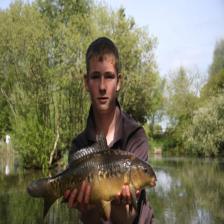

In [79]:
#DEBUG

# new_file = 'data/imagenet/train/n01498041/n01498041_10412.JPEG'
new_file = 'data/imagenet/train/n01440764/n01440764_6878.JPEG'
new_im = Image.open(new_file).resize((224,224), Image.BILINEAR)
new_im

**================================ END DEBUG ================================**

In [97]:
arch = resnet50

In [106]:
# transformers of images for training
tfms = tfms_from_model(arch, 224, transforms_side_on, max_zoom=1.1)

md = ImageClassifierData.from_names_and_array(PATH, images, img_vecs, val_idxs=val_idxs,
                                              classes=None, tfms=tfms, continuous=True, bs=256)

In [107]:
x, y = next(iter(md.val_dl))

In [108]:
models = ConvnetBuilder(arch, md.c, is_multi=False, is_reg=True, xtra_fc=[1024], ps=[0.2, 0.2])

learn = ConvLearner(md, models, precompute=True)
learn.opt_fn = partial(optim.Adam, betas=(0.9, 0.99))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 72565393.28it/s]


100%|██████████| 16/16 [00:36<00:00,  2.28s/it]


In [109]:
def cos_loss(inp, targ):
    return 1 - F.cosine_similarity(inp, targ).mean()

learn.crit = cos_loss

In [110]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

 85%|████████▌ | 34/40 [00:02<00:00, 13.45it/s, loss=nan]  


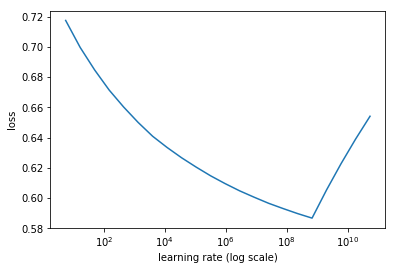

In [111]:
learn.sched.plot()

In [112]:
lr = 1e-2
wd = 1e-7

In [113]:
learn.precompute = True

In [114]:
learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss                             
    0      0.533586   0.470473  
    1      0.372923   0.486955                             
    2      0.293371   0.49963                              
    3      0.236202   0.505895                             
    4      0.195004   0.510554                             
    5      0.165844   0.516996                             
    6      0.144815   0.530448                             
    7      0.129941   0.523714                             
    8      0.117989   0.525584                             
    9      0.109467   0.523132                             
    10     0.102434   0.526665                             
    11     0.09594    0.528045                              
    12     0.090793   0.525027                              
    13     0.08635    0.530179                              
    14     0.082674   0.52541                               
    15     0.078416   0.524496                              
  

[array([0.52872])]

In [115]:
learn.bn_freeze(True)

In [116]:
learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      0.055475   0.533504  
    1      0.061694   0.543637                              
    2      0.069302   0.537233                              
    3      0.066792   0.538912                              
    4      0.059769   0.534378                              
    5      0.053277   0.531469                              
    6      0.048054   0.533863                              
    7      0.043353   0.534298                              
    8      0.039795   0.538832                              
    9      0.036677   0.538117                              
    10     0.033617   0.546751                              
    11     0.031627   0.539823                              
    12     0.029719   0.530515                              
    13     0.027769   0.547381                              
    14     0.025036   0.548819                              
    15     0.023828   0.538898                      

[array([0.54517])]

In [117]:
lrs = np.array([lr / 1000, lr / 100, lr])

In [118]:
learn.precompute = False
learn.freeze_to(1)

In [119]:
learn.save('pre0')

In [120]:
learn.load('pre0')

## Image search

### Search ImageNet classes

In [121]:
# syn_wv_1k is ImageNet 1000 classes (syn) mapped to fastText word vectors
syns, wvs = list(zip(*syn_wv_1k)) # split tuple of syn_id and word vector into 2 list, syn_ids, word vectors
wvs = np.array(wvs)

In [135]:
# DEBUG
syn_wv_1k[0][0], syn_wv_1k[0][1][:10]

('n01440764',
 array([ 0.01299,  0.51545, -0.02986, -0.17743, -0.13517,  0.09963,  0.15457, -0.29894,  0.06537, -0.32881],
       dtype=float32))

In [138]:
# DEBUG
syns[0], wvs[0][:10]

('n01440764',
 array([ 0.01299,  0.51545, -0.02986, -0.17743, -0.13517,  0.09963,  0.15457, -0.29894,  0.06537, -0.32881],
       dtype=float32))

In [139]:
%time pred_wv = learn.predict()

CPU times: user 1min 8s, sys: 4.99 s, total: 1min 13s
Wall time: 33.2 s


In [157]:
start = 512

In [141]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig, axes = plt.subplots(len(ims) // cols, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        show_img(ims[i], ax=ax)
    plt.tight_layout()

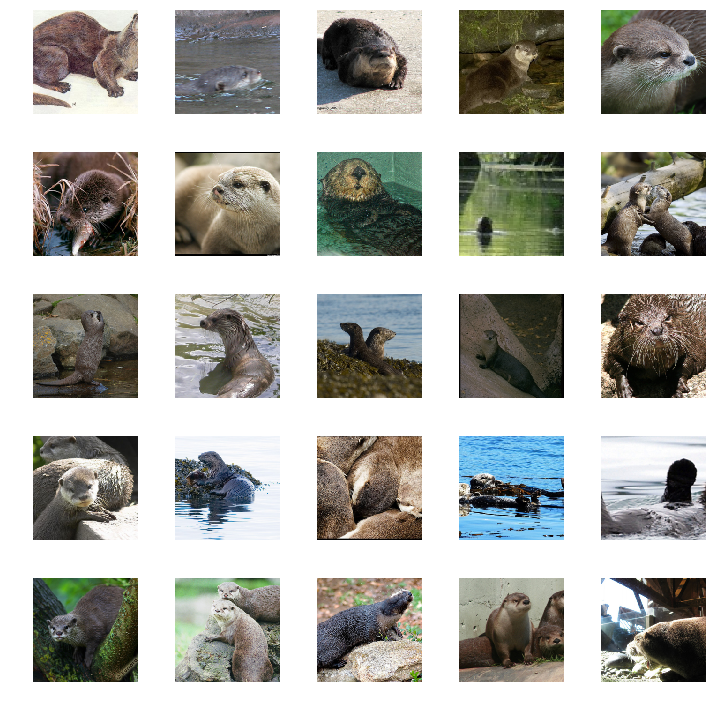

In [158]:
show_imgs(denorm(md.val_ds[start:start + 25][0]), 5, (10, 10))

## Nearest neighbor search

There is an amazing almost unknown library called NMSLib that does that incredibly fast. The library uses multi-threading and is absolutely fantastic. You can install from pip (`pip install nmslib`) and it just works.

In [161]:
!pip install nmslib

    100% |████████████████████████████████| 256kB 1.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for nmslib ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/01/5d/03/201cc23dfe226021fd08f1eac9d03df73473eed25ed4e557c7
Successfully built nmslib
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [162]:
import nmslib

In [166]:
def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
    return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec):
    return index.knnQuery(vec, k=10)

In [164]:
nn_wvs = create_index(wvs)

In [167]:
idxs, dists = get_knns(nn_wvs, pred_wv)

In [193]:
# DEBUG
wn_p = list(zip(list(classids.keys()), list(classids.values())))[100:105]
print(wn_p)
syns[0]

[('n00045646', 'rally'), ('n00045907', 'recovery'), ('n00046177', 'running_away'), ('n00046344', 'stunt'), ('n00046522', 'touch')]


'n01440764'

In [194]:
# ImageNet classes
[ [classids[syns[id]] for id in ids[:3]] for ids in idxs[start:start + 10] ]

[['mink', 'polecat', 'cougar'],
 ['badger', 'polecat', 'otter'],
 ['marmot', 'badger', 'polecat'],
 ['marmot', 'badger', 'mink'],
 ['polecat', 'badger', 'skunk'],
 ['mink', 'polecat', 'beaver'],
 ['polecat', 'cougar', 'badger'],
 ['dingo', 'wombat', 'polecat'],
 ['cockroach', 'bathtub', 'plunger'],
 ['polecat', 'skunk', 'mink']]

### Search all WordNet noun classes

In [204]:
# DEBUG

# syn2wv is of type dict
syn2wv['n00001740'][:10] # returns 300 dimensional word vector

array([ 0.02561,  0.17057, -0.12382,  0.3527 , -0.06303,  0.08731,  0.14308, -0.32462, -0.31296,  0.09208],
      dtype=float32)

In [205]:
all_syns, all_wvs = list(zip(*syn2wv.items()))
all_wvs = np.array(all_wvs)

In [217]:
# DEBUG
all_syns[0], all_wvs[0][:10]

('n00001740',
 array([ 0.02561,  0.17057, -0.12382,  0.3527 , -0.06303,  0.08731,  0.14308, -0.32462, -0.31296,  0.09208],
       dtype=float32))

In [211]:
# nearest neigbour for all word vectors for WordNet noun classes
nn_allwvs = create_index(all_wvs)

In [212]:
idxs, dists = get_knns(nn_allwvs, pred_wv)

In [219]:
[ [classids[all_syns[id]] for id in ids[:3]] for ids in idxs[start:start + 10] ]

[['mink', 'mink', 'mink'],
 ['badger', 'polecat', 'raccoon'],
 ['marmot', 'Marmota', 'badger'],
 ['marmot', 'Marmota', 'badger'],
 ['polecat', 'Mustela', 'stoat'],
 ['mink', 'mink', 'mink'],
 ['polecat', 'Mustela', 'cougar'],
 ['dog', 'dog', 'alligator'],
 ['nosepiece', 'sweatband', 'sweatband'],
 ['polecat', 'Mustela', 'Melogale']]

### Text -> image search

In [220]:
nn_predwv = create_index(pred_wv)

In [221]:
en_vecd = pickle.load(open(TRANS_PATH / 'wiki.en.pkl', 'rb'))

In [231]:
def text2img(vec):
    # get indices and distances
    idxs, dists = get_knn(nn_predwv, vec)
    im_res = [open_image(PATH / md.val_ds.fnames[i]) for i in idxs[:3]]
    show_imgs(im_res, 3, figsize=(9, 3))

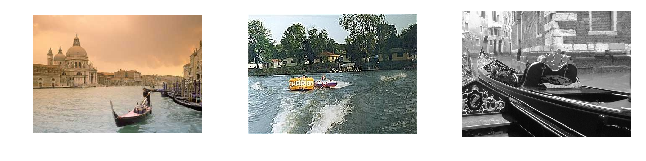

In [232]:
# en_vecd is of type dict. i.e { 'sink': 300-dim word vector }
vec = en_vecd['boat']
text2img(vec)

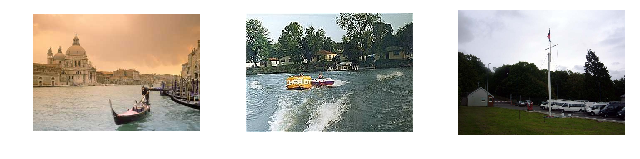

In [233]:
vec = (en_vecd['engine'] + en_vecd['boat']) / 2
text2img(vec)

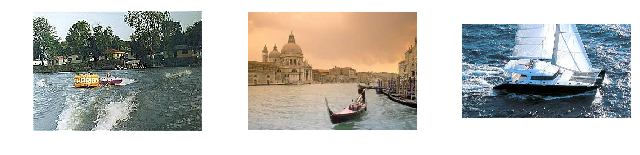

In [235]:
vec = (en_vecd['sail'] + en_vecd['boat']) / 2
text2img(vec)

### Image->image

In [238]:
fname = 'train/n01440764/n01440764_9649.JPEG'

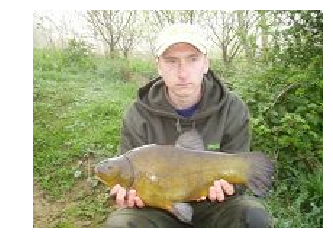

In [240]:
img = open_image(PATH / fname)
show_img(img)

In [241]:
t_img = md.val_ds.transform(img)
pred = learn.predict_array(t_img[None]) # t_img[None] give us batch size of 1

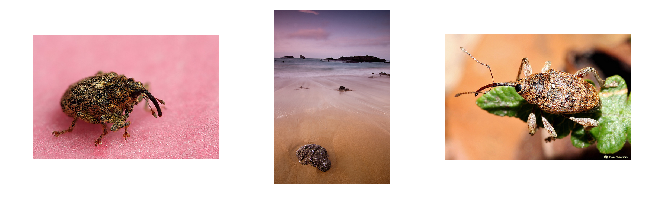

In [242]:
idxs, dists = get_knn(nn_predwv, pred) # pred is word vector, not probs
im_res = [open_image(PATH / md.val_ds.fnames[i]) for i in idxs[1:4]] # note we are getting idxs from 1 to 4, not 0 to 3.
show_imgs(im_res, 3, figsize=(9,3))

### Finish